In [1]:
import sys
sys.path.append("/home2/sdokania/all_projects/project-noisypixel/")

In [2]:
import os
import glob
import cv2
import random
import pandas as pd
from skimage import io
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import h5py

# Network building stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
import torch.distributions as dist


#mesh
from src.utils.libmise.mise import  MISE
from src.utils.libmcubes.mcubes import marching_cubes
import trimesh
from src.evaluate import *

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
DEVICE="cuda:0"

In [5]:
from src.models import *
from src.dataset.dataloader import OccupancyNetDatasetHDF
from src.trainer import ONetLit
from src.utils import Config, count_parameters

In [6]:
config = Config()
config.data_root = "/ssd_scratch/cvit/sdokania/processed_data/hdf_data/"
config.batch_size = 32
config.output_dir = '../occ_artifacts/'
config.exp_name = 'mesh_exp'
# config.encoder = "resnet-18"
# config.decoder = "decoder-cbn"
# config.c_dim = 256

config.encoder = "efficientnet-b0"
config.decoder = "decoder-cbn"
# config.c_dim = 256

Setting sexperiment path as : /home2/sdokania/all_projects/occ_artifacts/initial
Setting sexperiment path as : ../occ_artifacts/mesh_exp


In [7]:
vars(config)

{'c_dim': 128,
 'h_dim': 128,
 'p_dim': 3,
 'data_root': '/ssd_scratch/cvit/sdokania/processed_data/hdf_data/',
 'batch_size': 32,
 'output_dir': '../occ_artifacts/',
 '_exp_name': 'mesh_exp',
 'encoder': 'efficientnet-b0',
 'decoder': 'decoder-cbn',
 'lr': 0.0003,
 'exp_path': '../occ_artifacts/mesh_exp'}

In [8]:
onet = ONetLit(config)

Loaded pretrained weights for efficientnet-b0


In [9]:
net = ONetLit.load_from_checkpoint("../occ_artifacts/efficient_cbn_bs_64_full_data/lightning_logs/version_1/checkpoints/epoch=131-step=63359.ckpt", cfg=config).eval()
# net = ONetLit.load_from_checkpoint("../occ_artifacts/resnet50_fc_bs_64_full_data_balanced/lightning_logs/version_1/checkpoints/epoch=157-step=75770.ckpt", cfg=config).eval()
# net = ONetLit.load_from_checkpoint("../occ_artifacts/efficient_fcdecoder_bs_64_full_data/lightning_logs/version_1/checkpoints/epoch=129-step=62399.ckpt", cfg=config)

# net = ONetLit.load_from_checkpoint("../occ_artifacts/resnet18_cbn_bs_256_sub_data_balanced/lightning_logs/version_1/checkpoints/epoch=95-step=2495.ckpt", cfg=config).eval()

Loaded pretrained weights for efficientnet-b0


In [10]:
dataset = OccupancyNetDatasetHDF(config.data_root, num_points=2048, mode="test", point_cloud=True)
print(len(dataset))

8751


In [57]:
# mesh, mesh_data = get_mesh(dataset[0][:-1], return_points=True)


mesh_out_file = os.path.join('./', '%s.off' % 'onet')
opf = mesh.export(mesh_out_file)

In [12]:
empty_point_dict = {
    'completeness': np.sqrt(3),
    'accuracy': np.sqrt(3),
    'completeness2': 3,
    'accuracy2': 3,
    'chamfer': 6,
}

empty_normal_dict = {
    'normals completeness': -1.,
    'normals accuracy': -1.,
    'normals': -1.,
}

In [13]:
import datetime
import tqdm
import torch.distributions as dist
import pandas as pd

In [22]:
DEVICE="cuda:0"
nux = 0
start = datetime.datetime.now()
result = []

shuffled_idx = 100

test_img, test_pts, test_gt, pcl_gt, norm_gt = dataset[ix][:]
net.to(DEVICE)
pred_pts = net(test_img.unsqueeze(0).to(DEVICE), test_pts.unsqueeze(0).to(DEVICE)).cpu()
mesh, mesh_data, normals = get_mesh(net, (test_img.to(DEVICE), test_pts, test_gt), threshold_g=0.5, return_points=True)
pred_occ = dist.Bernoulli(logits=pred_pts).probs.data.numpy().squeeze()
result.append(eval_pointcloud(mesh_data[0], pcl_gt, normals, norm_gt, pred_occ, test_gt))

print(datetime.datetime.now() - start)
for kx in result[0]:
    if kx == "chamfer-L1":
        print("{}: {}".format(kx, result[0][kx]*10))
    else:
        print("{}: {}".format(kx, result[0][kx]))
    

mesh_out_file = os.path.join('./', '%s.off' % 'onet')
opf = mesh.export(mesh_out_file)

0:00:00.921384
completeness: 0.007918988902723943
accuracy: 0.008183860976921182
normals completeness: 0.8879243731498718
normals accuracy: 0.8527359366416931
normals: 0.8703301548957825
completeness_sq: 0.0001103035606231151
accuracy_sq: 0.00016926852475772773
chamfer-L2: 0.0001397860426904214
chamfer-L1: 0.08051424939822562
iou: 0.5555555820465088


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


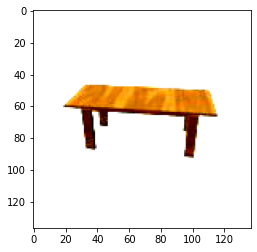

In [23]:
plt.imshow(test_img.transpose(0, 1).transpose(1,  2))